<a href="https://colab.research.google.com/github/covidba/covid/blob/master/covid19_jequie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolução da COVID-19 em Jequié/BA
**Fonte**: https://www.instagram.com/prefeiturajequie   
**Dados crus**: https://raw.githubusercontent.com/covidba/covid/master/jequie.csv   
**Github**: https://github.com/covidba/covid

In [0]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np

##from google.colab import drive
#drive.mount('/content/drive')
#fdir = '/content/drive/My Drive/Colab Notebooks/img/'

cidade = 'Jequié'
cidade_file_name = 'jequie'
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s.csv' % cidade_file_name
df = pd.read_csv(url, usecols=['data', 'confirmados','recuperados', 'mortes', 'tendencia'], parse_dates=['data'])
data_atual = (df['data'].max()).strftime("%d-%m-%Y")
df.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes', 'Expectativa']

#set date as index
lista_data = df['data']
df.set_index('data', inplace=True)
df.tail(10)

,Casos confirmados,Casos recuperados,Mortes,Expectativa
data,,,,
2020-05-13,128,76,3,104.116776
2020-05-14,142,80,3,114.016803
2020-05-15,145,81,3,124.854299
2020-05-16,149,81,3,136.717894
2020-05-17,153,81,3,149.704709
2020-05-18,162,82,3,163.919297
2020-05-19,182,82,3,179.478442
2020-05-20,201,83,4,196.508465
2020-05-21,219,88,6,215.147182


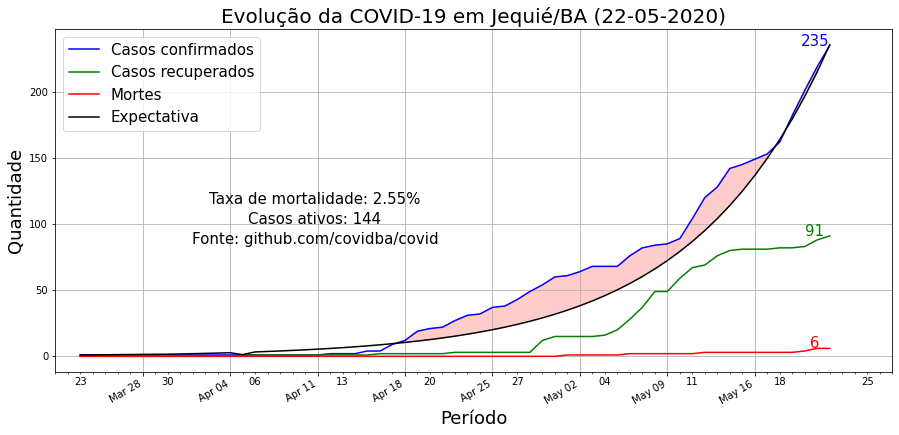

In [50]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
df.plot(ax=ax, color=colors)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

ax.annotate(df['Casos confirmados'].max(), xy=(lista_data.max(), df['Casos confirmados'].max()), 
            xycoords='data', ha='center', fontsize=15, color='b',
            xytext=(-15, 0), textcoords='offset points')
ax.annotate(df['Casos recuperados'].max(), xy=(lista_data.max(), df['Casos recuperados'].max()), 
            xycoords='data', ha='center', fontsize=15, color='g',
            xytext=(-15, 0), textcoords='offset points')
ax.annotate(df['Mortes'].max(), xy=(lista_data.max(), df['Mortes'].max()), 
            xycoords='data', ha='center', fontsize=15, color='r',
            xytext=(-15, 0), textcoords='offset points')

taxa_mortalidade = (100 * df['Mortes'].max()) / df['Casos confirmados'].max()
ax.annotate('Taxa de mortalidade: %.2f%%' % taxa_mortalidade , xy=(lista_data.max() - timedelta(days=40), 100), 
            xycoords='data', ha='center', fontsize=15, color='black',
            xytext=(-15, 20), textcoords='offset points')
casos_ativos = df['Casos confirmados'].max() - df['Casos recuperados'].max()
ax.annotate('Casos ativos: %s' % casos_ativos , xy=(lista_data.max() - timedelta(days=40), 100), 
            xycoords='data', ha='center', fontsize=15, color='black',
            xytext=(-15, 0), textcoords='offset points')

url_expectativa = 'github.com/covidba/covid'
ax.annotate('Fonte: %s' % url_expectativa , xy=(lista_data.max() - timedelta(days=40), 100), 
            xycoords='data', ha='center', fontsize=15, color='black',
            xytext=(-15, -20), textcoords='offset points')

ax.fill_between(df.index, df['Casos confirmados'], df['Expectativa'], where=df['Casos confirmados']>=df['Expectativa'], alpha=0.2, color='red')

ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max() + timedelta(days=5)])
ax.set_title("Evolução da COVID-19 em %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

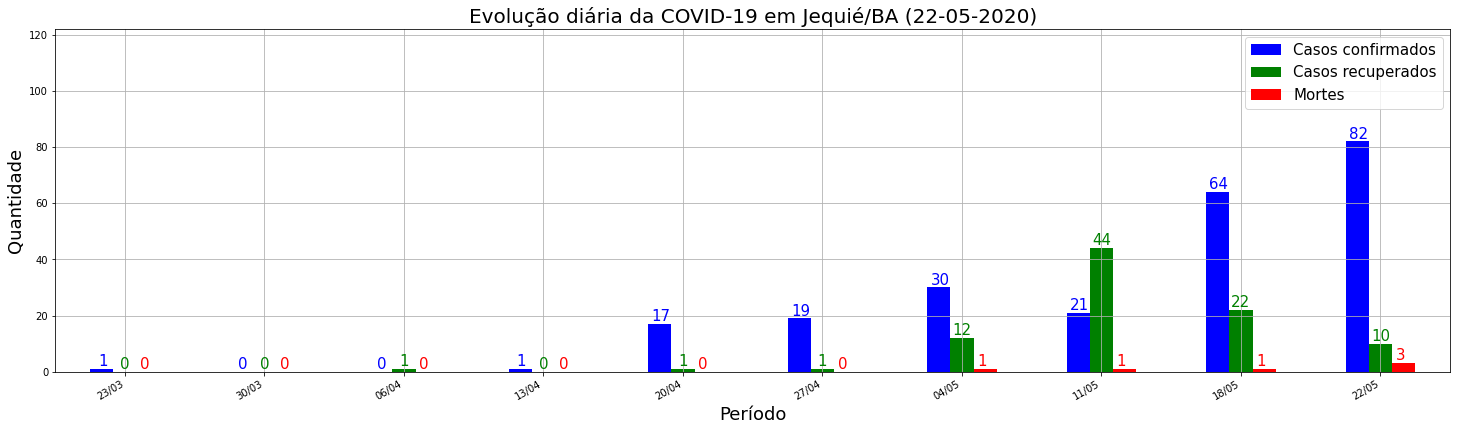

In [0]:
from matplotlib.dates import MO

dict_diaria = dict()
dict_diaria['data'] = []
dict_diaria['confirmados_diaria'] = []
dict_diaria['recuperados_diaria'] = []
dict_diaria['mortes_diaria'] = []

casos_confirmados_diaria = []
casos_recuperados_diaria = []
casos_mortes_diaria = []
for id, v in enumerate(df['Casos confirmados']):
  casos_confirmados_diaria.append(v) if(id) == 0 else casos_confirmados_diaria.append(v - df['Casos confirmados'][id-1])
for id, v in enumerate(df['Casos recuperados']):
  casos_recuperados_diaria.append(v) if(id) == 0 else casos_recuperados_diaria.append(v - df['Casos recuperados'][id-1])
for id, v in enumerate(df['Mortes']):
  casos_mortes_diaria.append(v) if(id) == 0 else casos_mortes_diaria.append(v - df['Mortes'][id-1])

frequency = 7
soma_casos = 0
a = 0
for id, v in enumerate(casos_confirmados_diaria):
  if id % frequency == 0:
    dict_diaria['data'].append(lista_data[id])
    if id == 0:
      dict_diaria['confirmados_diaria'].append(v)
    else:
      dict_diaria['confirmados_diaria'].append(soma_casos)
      soma_casos = v
  else:
    soma_casos += v
    if(len(casos_confirmados_diaria)-1 == id):
      dict_diaria['data'].append(lista_data[id])
      dict_diaria['confirmados_diaria'].append(soma_casos)
    
soma_casos = 0
for id, v in enumerate(casos_recuperados_diaria):
  if id % frequency == 0:
    if id == 0:
      dict_diaria['recuperados_diaria'].append(v)
    else:
      dict_diaria['recuperados_diaria'].append(soma_casos)
      soma_casos = v
  else:
    soma_casos += v
    if(len(casos_confirmados_diaria)-1 == id):
      dict_diaria['recuperados_diaria'].append(soma_casos)

soma_casos = 0
for id, v in enumerate(casos_mortes_diaria):
  if id % frequency == 0:
    if id == 0:
      dict_diaria['mortes_diaria'].append(v)
    else:
      dict_diaria['mortes_diaria'].append(soma_casos)
      soma_casos = v
  else:
    soma_casos += v
    if(len(casos_confirmados_diaria)-1 == id):
      dict_diaria['mortes_diaria'].append(soma_casos)

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes']
novo_df = df_diaria
df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(25,7))
df_diaria.plot(ax=ax, color=colors, kind='bar')
fig.autofmt_xdate()

# workaround para erro em bar kind
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df_diaria.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

for i, v in enumerate(df_diaria['Casos confirmados']):
  ax.annotate(v, xy=(i, v), xycoords='data', ha='center', fontsize=15, color='b',
            xytext=(-22, 3), textcoords='offset points')
  
for i, v in enumerate(df_diaria['Casos recuperados']):
  ax.annotate(v, xy=(i, v), xycoords='data', ha='center', fontsize=15, color='g',
            xytext=(0, 3), textcoords='offset points')
  
for i, v in enumerate(df_diaria['Mortes']):
  ax.annotate(v, xy=(i, v), xycoords='data', ha='center', fontsize=15, color='r',
            xytext=(20, 3), textcoords='offset points')

ax.set_ylim([0, df_diaria['Casos confirmados'].max() + 40])
ax.set_title("Evolução diária da COVID-19 em %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)